# Introduction au Reservoir Computing et à ReservoirPy

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

import reservoirpy as rpy
from reservoirpy.nodes import Reservoir, Ridge

rpy.verbosity(0)
# Rendre les résultats déterministes
rpy.set_seed(2341)

## Un exemple simple: Mackey-Glass

<class 'numpy.ndarray'> (2000, 1)


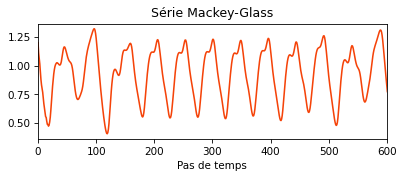

In [2]:
# Import de la série Mackey-Glass
from reservoirpy.datasets import mackey_glass

timeseries = mackey_glass(n_timesteps=2_000, tau=17, seed=260_418)

print(type(timeseries), timeseries.shape)

plt.figure(figsize=(6, 2))
plt.title("Série Mackey-Glass")
plt.plot(timeseries)
plt.xlim(0, 600)
plt.xlabel("Pas de temps")
plt.show()

(1580, 1) (400, 1) (1580, 1) (400, 1)


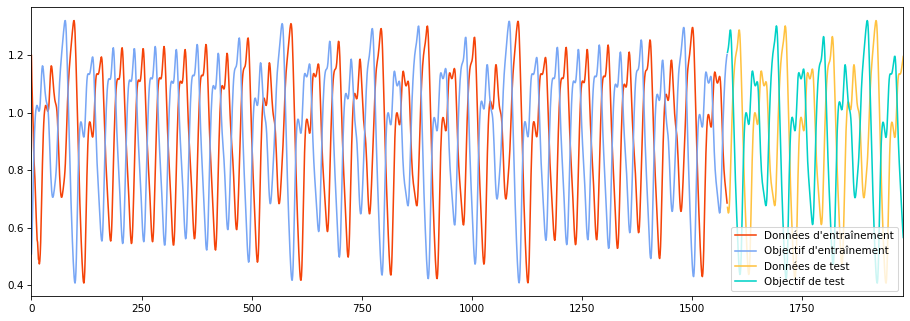

In [3]:
# Séparation X/Y et train/test
from reservoirpy.datasets import to_forecasting

X_train, X_test, Y_train, Y_test = to_forecasting(timeseries=timeseries, test_size=400, forecast=20)

print(
    X_train.shape,
    X_test.shape,
    Y_train.shape,
    Y_test.shape,
)
cutoff = X_train.shape[0]


plt.figure(figsize=(15, 5))
plt.plot(np.arange(0, 1580), X_train, label="Données d'entraînement")
plt.plot(np.arange(0, 1580), Y_train, label="Objectif d'entraînement")
plt.plot(np.arange(1580, 1980), X_test, label="Données de test")
plt.plot(np.arange(1580, 1980), Y_test, label="Objectif de test")
plt.legend()
plt.show()

In [4]:
# Créer le modèle
reservoir = Reservoir(
    units=500, # Nombre de neurones
    sr=1.25,   # Rayon spectral de la matrice de poids
    lr=0.3,    # Taux de décharge
    input_scaling=1. # Facteur multiplicatif de l'entrée
)
readout = Ridge(ridge=1e-4) # Régularisation: pénalise le sur-apprentissage
model = reservoir >> readout

In [5]:
# Entraîner le modèle sur les données d'entraînement
model.fit(X_train, Y_train)

'Model-0': Model('Reservoir-0', 'Ridge-0')

In [6]:
# Évaluer le modèle sur les données de test
Y_pred = model.run(X_test)

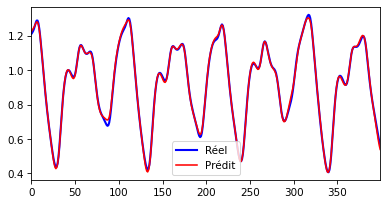

In [7]:
# Affichage des résultats
plt.figure(figsize=(6, 3))
plt.plot(Y_test, color="blue", linewidth=2, label="Réel")
plt.plot(Y_pred, color="red", label="Prédit")
plt.legend()
plt.show()

### Auscultons le réservoir

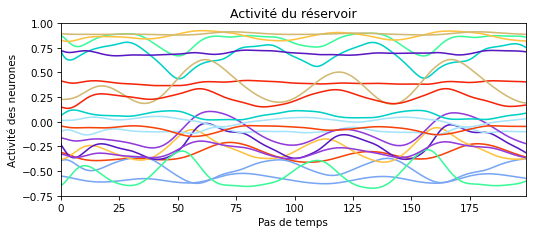

In [8]:
activity = reservoir.run(X_test)

plt.figure(figsize=(8, 3))
plt.plot(activity[:200, :20]) # 200 pas de temps, 20 neurones
plt.title("Activité du réservoir")
plt.xlabel("Pas de temps")
plt.ylabel("Activité des neurones")
plt.show()

## Prédiction univariée (Consommation électrique sur le réseau français)

Lancé en 2011, [www.data.gouv.fr](www.data.gouv.fr) est un site gouvernemental français qui met à disposition plus de 45 000 jeux de données sous licence libre.

RTE (Réseau de Transport de l'Électricité) propose au grand public des informations historiques et [en temps réel](https://www.rte-france.com/eco2mix/la-consommation-delectricite-en-france) sur la consommation électrique sur le réseau en France.

Le jeu de données suivant, ainsi mis à disposition par RTE sur la plateforme [www.data.gouv.fr](www.data.gouv.fr), est une série temporelle qui présente la consommation électrique (en MW) du réseau par demi-heure, de 2012 à 2022.

Avec près de 200 000 pas de temps, il peut être intéressant d'évaluer des tâches de prédiction à plusieurs échelles de temps (en rééchantillonnant, par exemple via `np.reshape` puis `np.mean`).

__Lien de téléchargement :__ https://www.data.gouv.fr/fr/datasets/consommation-quotidienne-brute/

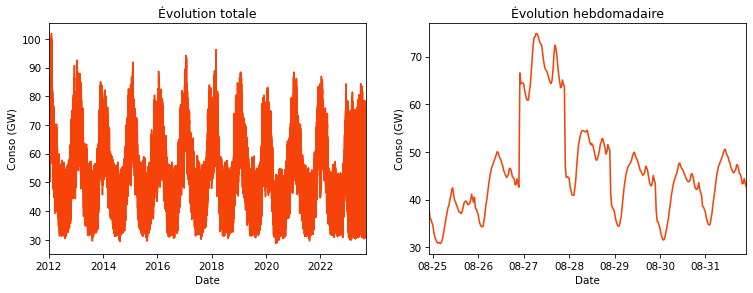

In [12]:
import pandas as pd
from matplotlib.dates import DateFormatter

# chargement du dataset
df_conso_rte = pd.read_csv('./conso_electricite_rte.csv')
# conversion de la colonne date_heure au bon type
df_conso_rte["date_heure"] = pd.to_datetime(df_conso_rte["date_heure"], utc=True)
# Affichage
plt.figure(figsize=(12, 4))

plt.subplot(1,2,1)
plt.title("Évolution totale")
plt.plot(np.array(df_conso_rte["date_heure"]), np.array(df_conso_rte["consommation_brute_electricite_rte"]) / 1e3)
plt.xlabel("Date")
plt.ylabel("Conso (GW)")

ax = plt.subplot(1,2,2)
plt.title("Évolution hebdomadaire")
plt.plot(np.array(df_conso_rte["date_heure"])[:2*24*7], np.array(df_conso_rte["consommation_brute_electricite_rte"])[:2*24*7] / 1e3)
plt.xlabel("Date")
plt.ylabel("Conso (GW)")
ax.xaxis.set_major_formatter(DateFormatter("%m-%d"))

plt.show()

In [10]:
# Pré-traitement
# Resampling journalier
consommation_demi_heure = df_conso_rte["consommation_brute_electricite_rte"].to_numpy()
consommation_jour = consommation_demi_heure[:-3].reshape((-1, 2*24, 1)).mean(axis=1)

# On vérifie que les dimensions du tableau sont bonnes
print(f"Dimensions des données: {consommation_jour.shape}")

# Normalisation
conso_min, conso_max = np.min(consommation_jour), np.max(consommation_jour)
consommation_jour = (consommation_jour - conso_min) / (conso_max - conso_min) - 0.5

# Forecast et séparation train/test
X_train, X_test, Y_train, Y_test = to_forecasting(timeseries=consommation_jour, forecast=5, test_size=0.2)

Dimensions des données: (4018, 1)


In [ ]:
# Création du modèle
#TODO

In [ ]:
# Entraînement du modèle
#TODO

In [ ]:
# Test du modèle
#TODO

In [ ]:
# Évaluation des performances du modèle
from reservoirpy.observables import nrmse
print(nrmse(y_true=Y_test, y_pred=Y_pred))

plt.figure()
plt.plot(Y_test, color="black", linewidth=3)
plt.plot(Y_pred, color="red")
plt.show()

In [ ]:
# Visualiser l'activité du réservoir
#TODO

### Exploration des hyper-paramètres

Vous pouvez consulter le [tutoriel ReservoirPy sur la recherche d'hyper-paramètres](https://github.com/reservoirpy/reservoirpy/blob/master/tutorials/4-Understand_and_optimize_hyperparameters.ipynb) pour plus de détails :)

In [ ]:
# Définition de la fonction objectif
from reservoirpy.observables import nrmse, rsquare

def objective(dataset, config, *, input_scaling, N, sr, lr, ridge, seed):
    x_train, y_train, x_test, y_test = dataset
    seed = int(seed)
    
    # Construction du modèle à partir des hyper-paramètres explorés
    reservoir = Reservoir(
        units=N, 
        sr=sr, 
        lr=lr, 
        input_scaling=input_scaling, 
        seed=seed,
    )
    readout = Ridge(ridge=ridge)

    model = reservoir >> readout

    y_pred = model.fit(x_train, y_train) \
                        .run(x_test)

    return {'loss': nrmse(y_test, y_pred, norm_value=np.ptp(x_train)),
            'r2': rsquare(y_test, y_pred)}

In [ ]:
import json

hyperopt_config = {
    "exp": "recherche_1",    # nom de l'expérience
    "hp_max_evals": 200,     # nombre d'itérations
    "hp_method": "random",   # méthode d'exploration
    "seed": 42,              # seed des paramètres sélectionnés
    "hp_space": {            # définition de l'espace exploré
        "N": ["choice", 500],             # réservoirs à 500 neurons
        "sr": ["loguniform", 1e-2, 10],   # rayon spectral exploré log-uniformément entre 0.01 et 10
        "lr": ["loguniform", 1e-3, 1],    # idem avec le taux de décharge, de 1e-3 à 1
        "input_scaling": ["loguniform", 1e-2, 10], # on fixe l'input scaling à 1
        "ridge": ["loguniform", 1e-8, 1e1], # régularisation, log-exploré entre 10^-8 à 1
        "seed": ["uniform", 1, 10000]       # seed d'initialisation du réservoir
    }
}

# we precautionously save the configuration in a JSON file
# each file will begin with a number corresponding to the current experimentation run number.
with open(f"{hyperopt_config['exp']}.config.json", "w+") as f:
    json.dump(hyperopt_config, f)


In [ ]:
from reservoirpy.hyper import research

dataset = (X_train, Y_train, X_test, Y_test)
best = research(objective, dataset, f"{hyperopt_config['exp']}.config.json", ".")

In [ ]:
from reservoirpy.hyper import plot_hyperopt_report
fig = plot_hyperopt_report(hyperopt_config["exp"], ("lr", "sr", "ridge"), metric="r2")

## Classification de séries temporelles: FordA

On prend ici un jeu de données de classification :

Le problème de classification consiste à diagnostiquer si un certain symptôme existe ou non dans un sous-système automobile. Chaque cas se compose de 500 mesures du bruit du moteur et d'une classification.
http://timeseriesclassification.com/description.php?Dataset=FordA

[Guide de la classification avec ReservoirPy](https://github.com/reservoirpy/reservoirpy/blob/master/tutorials/5-Classification-with-RC.ipynb)

In [ ]:
import pickle

with open("./datasets/FordA.p", 'rb') as file:
    fordA = pickle.load(file)

print(
    type(fordA),
    fordA[0].shape, # X_train
    fordA[1].shape, # Y_train
    fordA[2].shape, # X_test
    fordA[3].shape, # Y_test
)

### Pré-traitement

Pour ReservoirPy, toutes les données sont des séries temporelles. Ce qui n'est pas le cas ici pour les données à prédire en classification. Réglons ça.

In [ ]:
X_train = fordA[0]
Y_train = fordA[1]
X_test = fordA[2]
Y_test = fordA[3]

Y_train = np.repeat(Y_train.reshape(-1, 1, 1), 500, axis=1)
Y_test = np.repeat(Y_test.reshape(-1, 1, 1), 500, axis=1)

### Création d'un modèle et entraînement

In [ ]:
# Création du modèle
#TODO

In [ ]:
# Entraîner le modèle à classifier
#TODO

In [ ]:
# Lancer le modèle sur l'ensemble de test
#TODO

In [ ]:
# Décoder les prédictions
# Il faut avoir 1 sortie par série !
#TODO

In [ ]:
# Affichage des résultats
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

print(classification_report(y_true=Y_test, y_pred=Y_pred))

_ = ConfusionMatrixDisplay.from_predictions(y_true=Y_test, y_pred=Y_pred)

### Exploration des hyper-paramètres

In [ ]:
# Définition de la fonction objectif
#TODO

In [ ]:
# Configuration de la recherche
#TODO

In [ ]:
# Lancement de la recherche
#TODO

In [ ]:
# Affichage de l'exploration
#TODO